In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from scipy.stats import chisquare
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import gc
import lightgbm as lgbm
from sklearn.utils import class_weight
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report
from scipy import stats

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [109]:
adult20_path = '/content/drive/MyDrive/NHIS-Datasets/adult20.csv'
adult20long_path = '/content/drive/MyDrive/NHIS-Datasets/adult20long.csv'
adult20 = pd.read_csv(adult20_path)
adult20long = pd.read_csv(adult20long_path)

In [110]:
adult20_new = pd.merge(adult20long, adult20, left_on = 'HHX_2020', right_on = 'HHX')
adult20_new.shape

(10415, 622)

Remove columns with 100% null values

In [111]:
data = adult20_new
null_columns = data.columns[data.isna().any()].tolist()
null_data = (100 * data[null_columns].isna().sum())/data.shape[0]
drop_null_columns = []
for column in null_columns:
  if null_data[column] == 100:
    drop_null_columns.append(column)
adult20_new.drop(columns = drop_null_columns, inplace=True)
columns = adult20_new.columns
print(adult20_new.shape)
print("Number of columns with null values =" , null_data.shape[0])

(10415, 615)
Number of columns with null values = 406


In [112]:
adult20_new = adult20_new.select_dtypes(exclude=['object'])
print(adult20_new.shape)

(10415, 612)


In [113]:
to_drop = ['SHTFLUY_A','ZOSTAVXYRP_A','SHINGRXYRP_A','WTFA_A','WTSA_L', 'PSTRAT', 'PPSU','SRVY_YR_x','SRVY_YR_y','RECTYPE_x','RECTYPE_y']
adult20_new.drop(to_drop, axis=1, inplace=True)
print(adult20_new.shape)

(10415, 601)


Identifying categorical and numeric data

In [114]:
columns = adult20_new.columns
print(len(columns))

601


In [115]:
cat2 = ['EDUC_A','HISPALLP_A', 'MAXEDUC_A','PLNWRKR1_A','PLNWRKR2_A',
        'SPOUSEDUC_A','PRTNREDUC_A','WLKLEISDAY_A','SUNSKIN_A','NUMINJTC_A','WLKTRANDAY_A',
        'REPWRKDYTC_A','EMDOCCUPR2_A','EMDINDSTR2_A']

num2 = ['WEIGHTLBTC_A', 'EMPDYSMSS2_A']

numeric_columns = ['HILASTMY_A', 'HINOTMYR_A', 'JNTPN_A', 'CIGNOW_A', 'SMK30D_A', 'CIG30D_A', 'CIGAR30D_A', 
                   'FDSSKIPDYS_A', 'FDSNEDAYS_A', 'AGEP_A', 'BLADDAGETC_A','BLOODAGETC_A',
                   'BONEAGETC_A','BRAINAGETC_A','BREASAGETC_A','CERVIAGETC_A','COLONAGETC_A','ESOPHAGETC_A',
                   'LEUKEAGETC_A','LIVERAGETC_A','LUNGAGETC_A','LYMPHAGETC_A','MELANAGETC_A','MOUTHAGETC_A','OVARYAGETC_A','PANCRAGETC_A',
                   'PROSTAGETC_A','RECTUAGETC_A','SKNMAGETC_A','SKNNMAGETC_A','SKNDKAGETC_A','STOMAAGETC_A','THROAAGETC_A','THYROAGETC_A',
                   'UTERUAGETC_A','HDNCKAGETC_A','COLRCAGETC_A','OTHERAGETC_A','DIBAGETC_A','DIFYRSTC_A','HEIGHTTC_A','WEIGHTLBTC_A',
                   'HICOSTR1_A','HICOSTR2_A','PSA5YRTC_A','SHTHPVAGEP_A','SPOUSAGETC_A','PRTNRAGETC_A','SCHDYMSSTC_A','EMPWKHRS2_A','EMPDYSMSS2_A',
                   'FAMINCTC_A','POVRATTC_A','RATCAT_A','SMKAGE_A','DRK12MN_A','WLKTRANTPD_A','LARYNAGETC_A',
                   'WLKLEISTPD_A','EMDINDSTR1_A','STRFREQW_A','SHTFLUM_A','DRK12MWK_A','MODFREQW_A','INJWRKDYTC_A',
                   'STRNR_A','WLKLEISTC_A','SMKQTY_A','NUMBRNTC_A','EMDOCCUPR1_A','DRK12MYR_A','DRKAVG12M_A','VIGLNR_A','FORVARCIG_A','VIGFREQW_A',
                   'ASDYS12MTC_A','SLPHOURS_A','DRKAVG12M1_A','MODNR_A','DRK12MN1_A','VIGMIN_A','WLKTRANTC_A','MODLNR_A','VIGNR_A',
                   'SMKQTNP_A','MODMIN_A','MODMIN_A','DRKBNG30D_A','FORNUMCIG_A','GALLBAGETC_A']
categorical_columns = list(set(columns).difference(numeric_columns))
cat1 = list(set(categorical_columns).difference(cat2))
print("The dataset has {} total columns, out of which {} are numerical and {} are categorical.".format(len(columns), len(numeric_columns), len(categorical_columns)))

The dataset has 601 total columns, out of which 90 are numerical and 515 are categorical.


Replacing "refused", "don't know" ... etc values with Null

In [116]:
for column in cat2:  
  adult20_new[column].replace(to_replace=[97,98,99],value=np.NAN,inplace=True)
  
for column in cat1:  
  adult20_new[column].replace(to_replace=[7,8,9],value=np.NAN,inplace=True)

In [117]:
adult20_new = pd.get_dummies(adult20_new, columns = categorical_columns)
adult20_new.head()

,RATCAT_A,FAMINCTC_A,WLKLEISTC_A,WLKTRANTC_A,NUMBRNTC_A,SCHDYMSSTC_A,PRTNRAGETC_A,SPOUSAGETC_A,INJWRKDYTC_A,EMPDYSMSS2_A,...,PLNEXCHG2_A_1.0,PLNEXCHG2_A_2.0,DIBPILL_A_1.0,DIBPILL_A_2.0,COMBAT_A_1.0,COMBAT_A_2.0,ADVEAT_A_1.0,ADVEAT_A_2.0,WCHAIR_A_1.0,WCHAIR_A_2.0
0,14,100000,NaN,NaN,NaN,NaN,NaN,80.0,NaN,NaN,...,0,0,0,0,0,1,0,1,0,0
1,11,75000,30.0,NaN,4.0,NaN,NaN,NaN,NaN,1.0,...,0,0,0,0,0,0,0,1,1,0
2,14,90000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,0,0,0,0,0,0,0,1,0,0
3,5,39482,45.0,NaN,NaN,NaN,NaN,64.0,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
4,14,77605,10.0,NaN,NaN,NaN,NaN,85.0,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0


In [118]:
def find_null(data):
  null_columns = data.columns[data.isna().any()].tolist()
  null_data = (100 * data[null_columns].isna().sum())/data.shape[0]
  print(null_data.head())
  print("Number of columns with null values =" , null_data.shape[0])

In [119]:
find_null(adult20_new)

WLKLEISTC_A     38.722996
WLKTRANTC_A     87.028325
NUMBRNTC_A      74.872780
SCHDYMSSTC_A    95.525684
PRTNRAGETC_A    94.431109
dtype: float64
Number of columns with null values = 73


Drop columns with more than 90% null values

In [120]:
threshold = 0.1 * adult20_new.shape[0]
adult20_new = adult20_new.dropna( axis = 1, thresh = threshold)
print(adult20_new.shape[1])

1484


In [121]:
find_null(adult20_new)

WLKLEISTC_A     38.722996
WLKTRANTC_A     87.028325
NUMBRNTC_A      74.872780
SPOUSAGETC_A    54.555929
EMPDYSMSS2_A    39.913586
dtype: float64
Number of columns with null values = 30


Implement MICE in batches, otherwise RAM usage will exceed.
Free memory as we go, otherwise reading dataframes will cause memory to be completely used up.

In [122]:
lr = LinearRegression()
imp = IterativeImputer(estimator=lr,missing_values=np.nan, max_iter=1, verbose=2, imputation_order='roman',random_state=0)
number_of_columns = adult20_new.shape[1]
total_df = pd.DataFrame()
for i in range(0, number_of_columns, 87):
  temp = adult20_new.iloc[:,i:i+87]
  cols = temp.columns
  adult19_transformed = imp.fit_transform(temp)
  adult19_temp = pd.DataFrame(adult19_transformed, columns=cols)
  total_df = pd.concat([total_df, adult19_temp],axis=1 )
  print(total_df.shape)
  del(temp)
  del(adult19_transformed)
  del(adult19_temp)
  gc.collect()  

[IterativeImputer] Completing matrix with shape (10415, 87)
[IterativeImputer] Ending imputation round 1/1, elapsed time 6.75
[IterativeImputer] Change: 341165.2323150555, scaled tolerance: 250.0 
(10415, 87)
[IterativeImputer] Completing matrix with shape (10415, 87)
[IterativeImputer] Ending imputation round 1/1, elapsed time 22.60
[IterativeImputer] Change: 0.0, scaled tolerance: 0.001 
[IterativeImputer] Early stopping criterion reached.
(10415, 174)
[IterativeImputer] Completing matrix with shape (10415, 87)
[IterativeImputer] Ending imputation round 1/1, elapsed time 15.06
[IterativeImputer] Change: 0.0, scaled tolerance: 0.001 
[IterativeImputer] Early stopping criterion reached.
(10415, 261)
[IterativeImputer] Completing matrix with shape (10415, 87)
[IterativeImputer] Ending imputation round 1/1, elapsed time 7.10
[IterativeImputer] Change: 0.0, scaled tolerance: 0.001 
[IterativeImputer] Early stopping criterion reached.
(10415, 348)
[IterativeImputer] Completing matrix with 

In [123]:
find_null(total_df)

Series([], dtype: float64)
Number of columns with null values = 0


Normalize Numerical columns


In [ ]:
scaler = RobustScaler()
numeric_cols = total_df.columns.intersection(numeric_columns)
scaler = scaler.fit(total_df[numeric_cols])

total_df.loc[:, numeric_cols] = scaler.transform(total_df[numeric_cols].to_numpy())

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


In [ ]:
total_df.head()

,RATCAT_A,FAMINCTC_A,WLKLEISTC_A,WLKTRANTC_A,NUMBRNTC_A,SPOUSAGETC_A,EMPDYSMSS2_A,EMPWKHRS2_A,EMDOCCUPR1_A,EMDINDSTR1_A,...,PLNEXCHG2_A_1.0,PLNEXCHG2_A_2.0,DIBPILL_A_1.0,DIBPILL_A_2.0,COMBAT_A_1.0,COMBAT_A_2.0,ADVEAT_A_1.0,ADVEAT_A_2.0,WCHAIR_A_1.0,WCHAIR_A_2.0
0,0.428571,0.520548,0.953756,-2.044906,-1.501914,0.790720,0.994367,0.523527,0.319504,0.083486,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.000000,0.178082,-0.297253,0.808992,-0.115657,-0.557232,-0.010989,8.058555,-0.520080,0.555556,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,0.428571,0.383562,0.004394,0.016803,-0.415284,-0.461115,-0.013737,0.000000,-1.058734,0.555556,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-0.857143,-0.308466,0.532195,0.579296,1.546063,0.220914,1.015923,-0.338761,0.458269,0.075216,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.428571,0.213767,-1.403183,-1.631864,-1.120342,0.968785,0.989446,-0.180607,0.232812,0.794168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
# total_df.to_csv('NHIS-2019_cleaned.csv')

Correlation matrix with Pearson's coefficient

In [ ]:
# corr_matrix = total_df.corr()
# print(corr_matrix['DEPEV_A_1.0'].sort_values(ascending=False)[:20])

DEPEV_A_1.0         1.000000
DEPMED_A_1.0        0.638508
ANXEV_A_1.0         0.550975
ANXMED_A_1.0        0.490637
MHTHRPY_A_1.0       0.385734
DEPFREQ_A_1.0       0.345055
DEPLEVEL_A_2.0      0.344176
MHTPYNOW_A_1.0      0.341453
PHQ82_A_2.0         0.319614
ANXFREQ_A_1.0       0.305522
DEPFREQ_A_2.0       0.304983
DEPLEVEL_A_3.0      0.297396
COGTYPEDFF_A_3.0    0.280699
PHQ84_A_4.0         0.273941
GAD73_A_4.0         0.270040
ANXLEVEL_A_2.0      0.258422
PHQCAT_A_4.0        0.258274
GAD72_A_4.0         0.257579
PHQCAT_A_3.0        0.256739
PHQ81_A_2.0         0.253964
Name: DEPEV_A_1.0, dtype: float64


point biserial correlation is used to measure the relationship between a binary variable, x, and a continuous variable, y

Chi-square test of indepedence if both categorical

H0: Variables are independent
Ha: Variable are not independent

In [124]:
corr_dict = {}
independent_cols = []
for col in total_df.columns:
  if col in numeric_columns:
    pvalue = stats.pointbiserialr(total_df[col],total_df['DEPEV_A_1.0'] ).pvalue
    if pvalue < 0.05:
      corr_dict[col] = pvalue
    else:
      independent_cols.append(col)
  
  else:
    res = stats.contingency.crosstab(total_df[col],total_df['DEPEV_A_1.0']).count
    result = stats.chi2_contingency(res)
    if result.pvalue < 0.05:
      corr_dict[col] = result.pvalue
    else:
      independent_cols.append(col)

In [125]:
dependent_cols = []
corr_cols = corr_dict.keys()
corr_dict = sorted(corr_dict.items(), key=lambda x:x[1])
corr_dict = dict(corr_dict)
n = len(corr_dict)
l = list(corr_dict.items())
for i in range(n):
  dependent_cols.append(l[i][0])

Causal Analysis

In [126]:
! pip install bnlearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [127]:
# Select columns from dependent_cols list. independent_cols will give no edges in the graph
cols = [
 'EMPRSNOWK_A_4.0',
 'MHTHND_A_1.0',
 'SOCSCLPAR_A_4.0',
 'DEPEV_A_1.0'
 ]

[bnlearn] >Computing best DAG using [ex]
[bnlearn] >Set scoring type at [bic]
[bnlearn] >Compute structure scores ['k2', 'bds', 'bic', 'bdeu'] for model comparison (higher is better).
{}
[bnlearn] >Compute edge strength with [chi_square]
+----+-----------------+-----------------+-------------+-------------+--------------+-------+
|    | source          | target          | stat_test   |     p_value |   chi_square |   dof |
+====+=================+=================+=============+=============+==============+=======+
|  0 | DEPEV_A_1.0     | EMPRSNOWK_A_4.0 | True        | 2.30176e-78 |     351.217  |     1 |
+----+-----------------+-----------------+-------------+-------------+--------------+-------+
|  1 | DEPEV_A_1.0     | MHTHND_A_1.0    | True        | 1.74252e-89 |     402.296  |     1 |
+----+-----------------+-----------------+-------------+-------------+--------------+-------+
|  2 | DEPEV_A_1.0     | SOCSCLPAR_A_4.0 | True        | 2.56134e-16 |      67.1149 |     1 |
+----+----

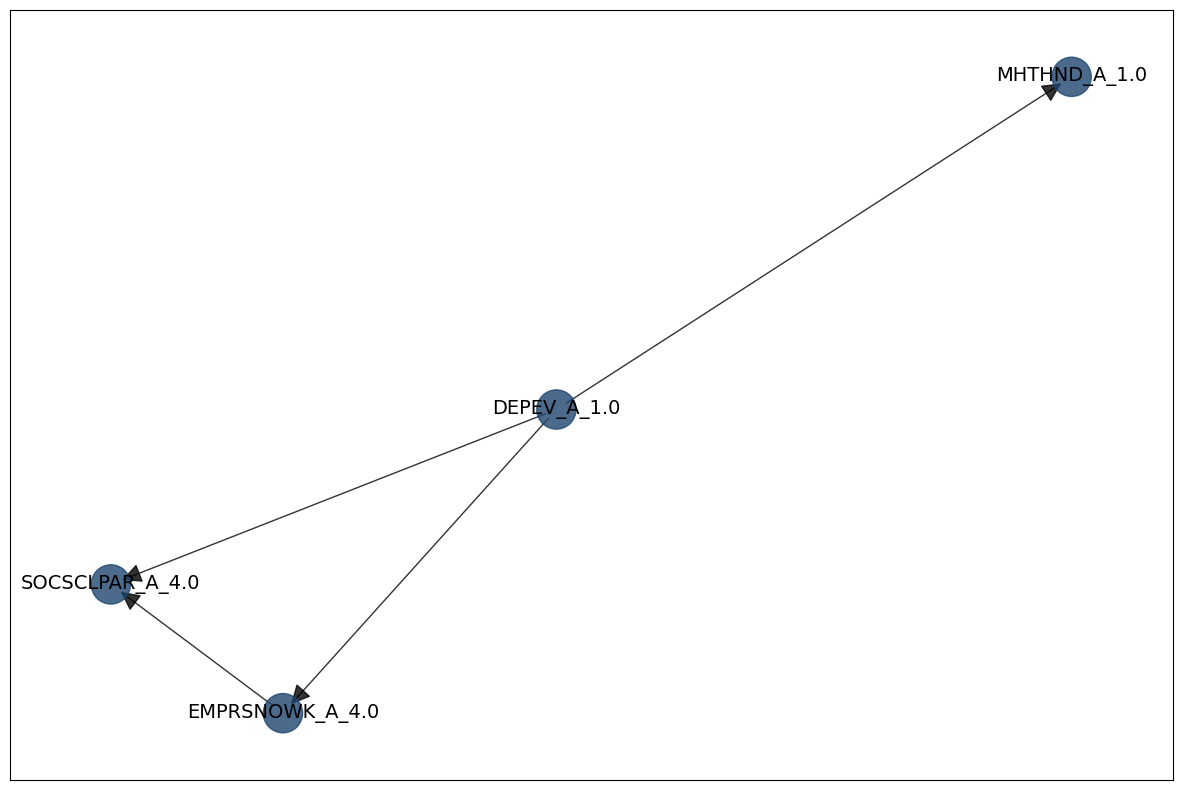

[bnlearn] >Set node properties.
[bnlearn]> Set edge weights based on the [chi_square] test statistic.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model


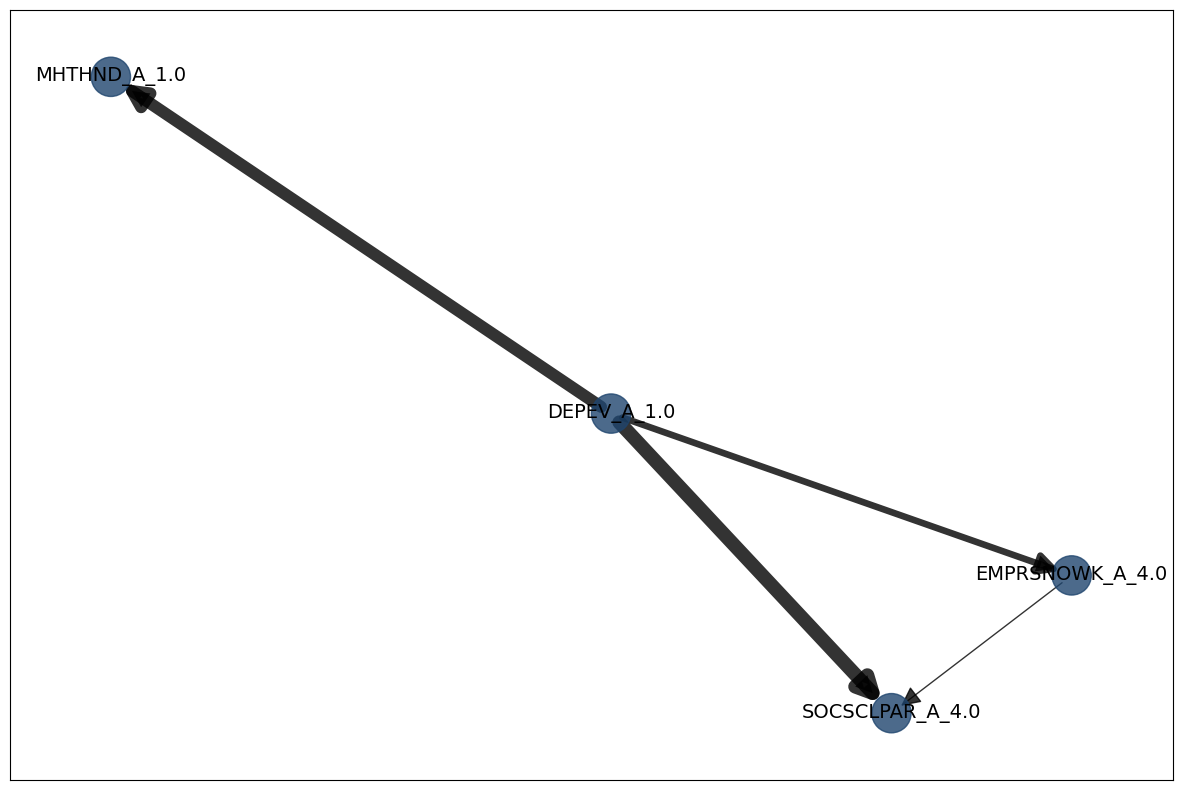

{'fig': <Figure size 1500x1000 with 1 Axes>,
 'ax': <Figure size 1500x1000 with 1 Axes>,
 'pos': {'DEPEV_A_1.0': array([-0.06453376,  0.08474189]),
  'EMPRSNOWK_A_4.0': array([ 0.42911845, -0.35515267]),
  'MHTHND_A_1.0': array([-0.60062412,  1.        ]),
  'SOCSCLPAR_A_4.0': array([ 0.23603942, -0.72958922])},
 'G': <networkx.classes.digraph.DiGraph at 0x7fedb787b160>,
 'node_properties': {'DEPEV_A_1.0': {'node_color': '#1f456e',
   'node_size': 800},
  'EMPRSNOWK_A_4.0': {'node_color': '#1f456e', 'node_size': 800},
  'MHTHND_A_1.0': {'node_color': '#1f456e', 'node_size': 800},
  'SOCSCLPAR_A_4.0': {'node_color': '#1f456e', 'node_size': 800}},
 'edge_properties': {('EMPRSNOWK_A_4.0',
   'SOCSCLPAR_A_4.0'): {'color': '#000000', 'weight': 4.746506041145786},
  ('DEPEV_A_1.0', 'EMPRSNOWK_A_4.0'): {'color': '#000000',
   'weight': 8.632067346617074},
  ('DEPEV_A_1.0', 'MHTHND_A_1.0'): {'color': '#000000', 'weight': 10.0},
  ('DEPEV_A_1.0', 'SOCSCLPAR_A_4.0'): {'color': '#000000', 'weight

In [128]:
import tensorflow as tf
import bnlearn as bn
from tabulate import tabulate

# df = bn.import_example()
# As an example we set the CPD at False which returns an "empty" DAG
# model = bn.import_DAG()
# Now we learn the parameters of the DAG using the df
DAG = bn.structure_learning.fit(total_df[cols], methodtype='ex')
CPDs = bn.print_CPD(DAG)
print(CPDs)
model = bn.independence_test(DAG, total_df[cols], alpha=0.05, prune=True)
print(tabulate(model['independence_test'], tablefmt="grid", headers="keys"))
G = bn.plot(DAG)
bn.plot(model)

(IGNORE after this) Implementing LightGBM model 

In [ ]:
# Split into Train Test Dataset
X = total_df.drop(['DEPEV_A_1.0','DEPEV_A_2.0'], axis=1)
y = total_df['DEPEV_A_1.0']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

Check for class imbalance. Plot class distribution for Depression

<Axes: >

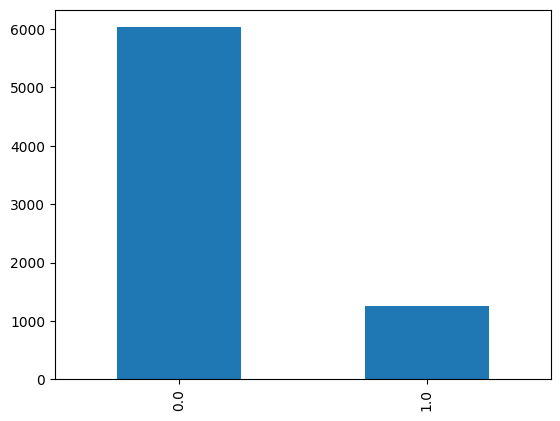

In [ ]:
y_train.value_counts().plot(kind='bar')

Compute class weights for training

In [ ]:
class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train                                                   
                                    )
class_weights = dict(zip(np.unique(y_train), class_weights))
print(class_weights)

{0.0: 0.6043773835184878, 1.0: 2.8951548848292297}


In [ ]:
model = lgbm.LGBMClassifier(class_weight=class_weights)
model.fit(X_train, y_train)

LGBMClassifier(class_weight={0.0: 0.6043773835184878, 1.0: 2.8951548848292297})

In [ ]:
y_pred = model.predict(X_test)
print("F1 Score:",f1_score(y_test, y_pred, average='macro'))
print("Recall:",recall_score(y_test, y_pred, average='macro'))

F1 Score: 0.843498972351652
Recall: 0.8574287388416877


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94      2563
         1.0       0.71      0.78      0.75       562

    accuracy                           0.90      3125
   macro avg       0.83      0.86      0.84      3125
weighted avg       0.91      0.90      0.91      3125



Confusion matrix, without normalization
[[2384  179]
 [ 121  441]]


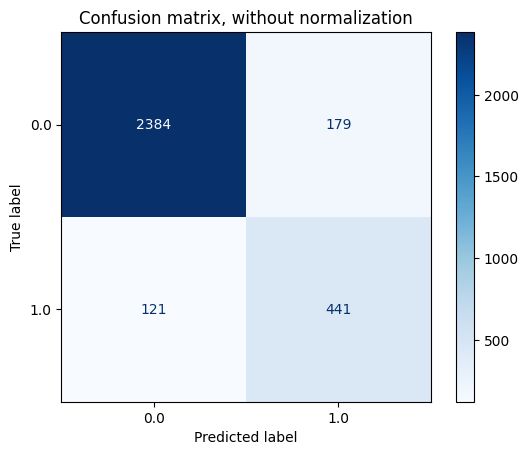

In [ ]:
titles_options = [
    ("Confusion matrix, without normalization", None)
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

Importance type = Gain. The average training loss reduction gained when using a feature for splitting.

Feature: 13, Score: 547.36527 JNTPN_A
Feature: 171, Score: 516.86347 PHQ84_A_1.0
Feature: 259, Score: 4063.15857 DEPMED_A_1.0
Feature: 422, Score: 633.23551 ANXEV_A_1.0
Feature: 423, Score: 5340.94321 ANXEV_A_2.0
Feature: 468, Score: 13606.23035 MHRX_A_2.0
Feature: 521, Score: 730.63038 PHQ82_A_1.0
Feature: 1287, Score: 3989.02920 DEPFREQ_A_5.0


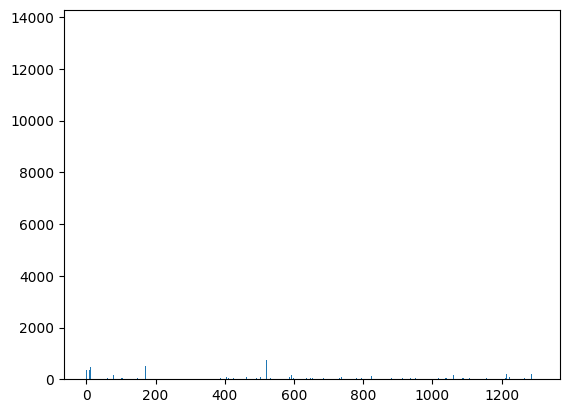

In [ ]:
# importance = model.feature_importances_
importance = model.booster_.feature_importance(importance_type='gain')
imp_cols = ['DEPEV_A_1.0']
for i,v in enumerate(importance):
  if v>500:
    imp_cols.append(X_train.columns[i])
    print('Feature: %0d, Score: %.5f %s' % (i,v, X_train.columns[i]))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()